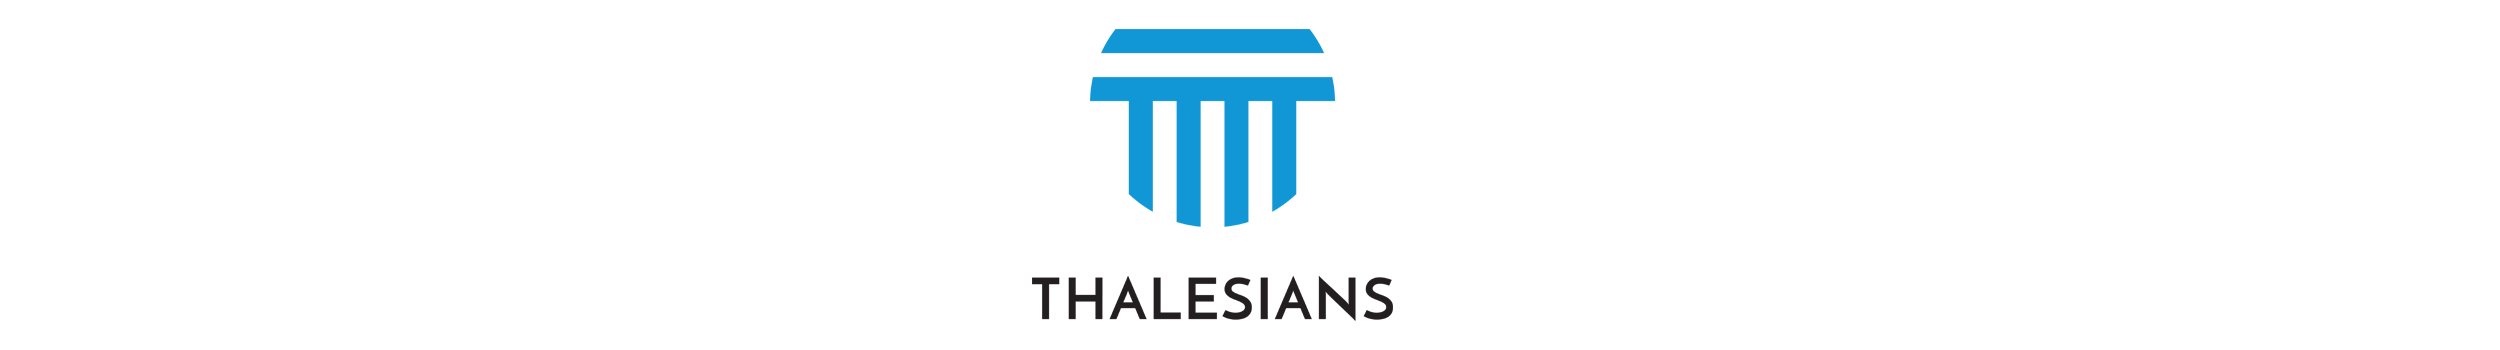

# Kalman filtering

## Introduction

Much thought has been given to the interfaces of the Kalman filter and related classes in thalesians.tsa. These interfaces and the underlying implementations incorporate many suggestions by Martin Zinkin.

Before we proceed, we import some Python modules:

In [1]:
import os, sys
sys.path.append(os.path.abspath('../../main/python'))

import datetime as dt

import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt

from thalesians.tsa.distrs import NormalDistr as N
import thalesians.tsa.filtering as filtering
import thalesians.tsa.filtering.kalman as kalman
import thalesians.tsa.numpyutils as npu
import thalesians.tsa.processes as proc

## A single-process, univariate example

First we need a **process model**. In this case it will be a single stochastic process,

In [2]:
process = proc.WienerProcess.create_from_cov(mean=3., cov=25.)

This we pass to a newly created Kalman filter, along with the initial time and initial state. The latter takes the form of a normal distribution. We have chosen to use Python `datetime`s as our data type for time, but we could have chosen `int`s or something else.

In [3]:
t0 = dt.datetime(2017, 5, 12, 16, 18, 25, 204000)
kf = filtering.kalman.KalmanFilter(t0, state_distr=N(mean=100., cov=250.), process=process)

Next we create an **observable**, which incorporates a particular **observation model**. In this case, the observation model is particularly simple, since we are observing the entire state of the Kalman filter. Our observation model is a 1x1 identity:

In [4]:
observable = kf.create_observable(kalman.LinearGaussianObsModel.create(1.), process)

Let's roll forward the time by one hour:

In [5]:
t1 = t0 + dt.timedelta(hours=1)

What is our predicted observation at this time? Since we haven't observed any actual information, this is our **prior** observation estimate:

In [6]:
prior_predicted_obs1 = observable.predict(t1)
prior_predicted_obs1

PredictedObs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[100.125]], cov=[[251.04166667]]), observable_name="KalmanObservable_2522333631096", cross_cov=[[251.04166667]])

We confirm that this is consistent with how our (linear-Gaussian) process model scales over time:

In [7]:
prior_predicted_obs1 = observable.predict(t1)
npt.assert_almost_equal(prior_predicted_obs1.distr.mean, 100. + 3./24.)
npt.assert_almost_equal(prior_predicted_obs1.distr.cov, 250. + 25./24.)
npt.assert_almost_equal(prior_predicted_obs1.cross_cov, prior_predicted_obs1.distr.cov)

Let us now actually *observe* our observation. Say, the observation is 100.35 and the observation noise covariance is 100.0:

In [8]:
observable.observe(time=t1, obs=N(mean=100.35, cov=100.0))

KalmanObsResult(accepted=True, obs=Obs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[100.35]], cov=[[100.]]), observable_name="KalmanObservable_2522333631096"), predicted_obs=PredictedObs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[100.125]], cov=[[251.04166667]]), observable_name="KalmanObservable_2522333631096", cross_cov=[[251.04166667]]), innov_distr=NormalDistr(mean=[[0.225]], cov=[[351.04166667]]), log_likelihood=[[-3.8494631]], gain=[[0.71513353]])

Having seen an actual observation, let us obtain the **posterior** observation estimate:

In [9]:
posterior_predicted_obs1 = observable.predict(t1); posterior_predicted_obs1

PredictedObs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[100.28590504]], cov=[[71.51335312]]), observable_name="KalmanObservable_2522333631096", cross_cov=[[71.51335312]])

We can now fast-forward the time, by two hours, say, and repeat the process:

In [10]:
t2 = t1 + dt.timedelta(hours=2)
        
prior_predicted_obs2 = observable.predict(t2)
npt.assert_almost_equal(prior_predicted_obs2.distr.mean, 100.28590504 + 2.*3./24.)
npt.assert_almost_equal(prior_predicted_obs2.distr.cov, 71.513353115 + 2.*25./24.)
npt.assert_almost_equal(prior_predicted_obs2.cross_cov, prior_predicted_obs2.distr.cov)
        
observable.observe(time=t2, obs=N(mean=100.35, cov=100.0))

posterior_predicted_obs2 = observable.predict(t2)
npt.assert_almost_equal(posterior_predicted_obs2.distr.mean, 100.45709020)
npt.assert_almost_equal(posterior_predicted_obs2.distr.cov, 42.395213845)
npt.assert_almost_equal(posterior_predicted_obs2.cross_cov, posterior_predicted_obs2.distr.cov)


## A multi-process, multivariate example

The real power of our Kalman filter interface is demonstrated for process models consisting of several (independent) stochastic processes:

In [11]:
process1 = proc.WienerProcess.create_from_cov(mean=3., cov=25.)
process2 = proc.WienerProcess.create_from_cov(mean=[1., 4.], cov=[[36.0, -9.0], [-9.0, 25.0]])

Such models are common in finance, where, for example, the dynamics of a yield curve may be represented by a (multivariate) stochastic process, whereas the idiosyncratic spread for each bond may be an independent stochastic process.

Let us pass `process1` and `process2` as a (compound) process model to our Kalman filter, along with the initial time and state:

In [12]:
t0 = dt.datetime(2017, 5, 12, 16, 18, 25, 204000)
kf = kalman.KalmanFilter(
    t0,
    state_distr=N(
        mean=[100.0, 120.0, 130.0],
        cov=[[250.0, 0.0, 0.0],
             [0.0, 360.0, 0.0],
             [0.0, 0.0, 250.0]]),
    process=(process1, process2))

We shall now create several **observables**, each corresponding to a distinct **observation model**. The first one will observe the entire state:

In [13]:
state_observable = kf.create_observable(
    kalman.LinearGaussianObsModel.create(1.0, np.eye(2)),
    process1, process2)

The second observable will observe the first coordinate of the first process:

In [14]:
coord0_observable = kf.create_observable(
    kalman.LinearGaussianObsModel.create(1.),
    process1)

The third, the first coordinate of the second process:

In [15]:
coord1_observable = kf.create_observable(
    kalman.LinearGaussianObsModel.create(npu.row(1., 0.)),
    process2)

The fourth, the second coordinate of the second process:

In [16]:
coord2_observable = kf.create_observable(
    kalman.LinearGaussianObsModel.create(npu.row(0., 1.)),
    process2)

The fifth will observe the sum of the entire state (across the two processes):

In [17]:
sum_observable = kf.create_observable(
    kalman.LinearGaussianObsModel.create(npu.row(1., 1., 1.)),
    process1, process2)

And the sixth a certain linear combination thereof:

In [18]:
lin_comb_observable = kf.create_observable(
    kalman.LinearGaussianObsModel.create(npu.row(2., 0., -3.)),
    process1, process2)

Fast-forward the time by one hour:

In [19]:
t1 = t0 + dt.timedelta(hours=1)

Let's predict the state at this time...

In [20]:
predicted_obs1_prior = state_observable.predict(t1)
predicted_obs1_prior

PredictedObs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[100.125     ]
 [120.04166667]
 [130.16666667]], cov=[[251.04166667   0.           0.        ]
 [  0.         361.5         -0.375     ]
 [  0.          -0.375      251.04166667]]), observable_name="KalmanObservable_2522334267656", cross_cov=[[251.04166667   0.           0.        ]
 [  0.         361.5         -0.375     ]
 [  0.          -0.375      251.04166667]])

And check that it is consistent with the scaling of the (multivariate) Wiener process with time:

In [21]:
npt.assert_almost_equal(predicted_obs1_prior.distr.mean,
                        npu.col(100.0 + 3.0/24.0, 120.0 + 1.0/24.0, 130.0 + 4.0/24.0))
npt.assert_almost_equal(predicted_obs1_prior.distr.cov,
                        [[250.0 + 25.0/24.0, 0.0, 0.0],
                         [0.0, 360.0 + 36.0/24.0, -9.0/24.0],
                         [0.0, -9.0/24.0, 250 + 25.0/24.0]])
npt.assert_almost_equal(predicted_obs1_prior.cross_cov, predicted_obs1_prior.distr.cov)

Suppose that a new observation arrives, and we observe each of the three coordinates individually:

In [22]:
state_observable.observe(time=t1, obs=N(mean=[100.35, 121.0, 135.0],
                                        cov=[[100.0, 0.0, 0.0],
                                             [0.0, 400.0, 0.0],
                                             [0.0, 0.0, 100.0]]));

Let's look at our (posterior) predicted state:

In [23]:
state_observable.predict(t1)

PredictedObs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[100.28590504]
 [120.49389518]
 [133.62301024]], cov=[[ 7.15133531e+01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.89888268e+02 -5.61129255e-02]
 [ 0.00000000e+00 -5.61129255e-02  7.15133381e+01]]), observable_name="KalmanObservable_2522334267656", cross_cov=[[ 7.15133531e+01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.89888268e+02 -5.61129255e-02]
 [ 0.00000000e+00 -5.61129255e-02  7.15133381e+01]])

Let's also look at the predictions for the individual coordinates:

In [24]:
coord0_observable.predict(t1)

PredictedObs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[100.28590504]], cov=[[71.51335312]]), observable_name="KalmanObservable_2522334266424", cross_cov=[[71.51335312  0.          0.        ]])

In [25]:
coord1_observable.predict(t1)

PredictedObs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[120.49389518]], cov=[[189.88826767]]), observable_name="KalmanObservable_2522334269000", cross_cov=[[ 0.00000000e+00  1.89888268e+02 -5.61129255e-02]])

In [26]:
coord2_observable.predict(t1)

PredictedObs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[133.62301024]], cov=[[71.51333813]]), observable_name="KalmanObservable_2522334269224", cross_cov=[[ 0.00000000e+00 -5.61129255e-02  7.15133381e+01]])

The predicted sum:

In [27]:
sum_observable.predict(t1)

PredictedObs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[354.40281047]], cov=[[332.80273306]]), observable_name="KalmanObservable_2522334266984", cross_cov=[[ 71.51335312 189.83215474  71.4572252 ]])

And the predicted linear combination:

In [28]:
lin_comb_observable.predict(t1)

PredictedObs(time=2017-05-12 17:18:25.204000, distr=NormalDistr(mean=[[-200.29722063]], cov=[[929.67345563]]), observable_name="KalmanObservable_2522333631992", cross_cov=[[ 1.43026706e+02  1.68338777e-01 -2.14540014e+02]])

Let's now go 30 minutes into the future:

In [29]:
t2 = t1 + dt.timedelta(minutes=30)

And observe only the first coordinate of the second process, with a pretty high confidence:

In [30]:
coord1_observable.observe(time=t2, obs=N(mean=125.25, cov=4.))

KalmanObsResult(accepted=True, obs=Obs(time=2017-05-12 17:48:25.204000, distr=NormalDistr(mean=[[125.25]], cov=[[4.]]), observable_name="KalmanObservable_2522334269000"), predicted_obs=PredictedObs(time=2017-05-12 17:48:25.204000, distr=NormalDistr(mean=[[120.51472852]], cov=[[190.63826767]]), observable_name="KalmanObservable_2522334269000", cross_cov=[[  0.         190.63826767  -0.24361293]]), innov_distr=NormalDistr(mean=[[4.73527148]], cov=[[194.63826767]]), log_likelihood=[[-3.61211113]], gain=[[ 0.        ]
 [ 0.97944906]
 [-0.00125162]])

How does our predicted state change?

In [31]:
state_observable.predict(t2)

PredictedObs(time=2017-05-12 17:48:25.204000, distr=NormalDistr(mean=[[100.34840504]
 [125.1526857 ]
 [133.70041682]], cov=[[ 7.20341864e+01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.91779623e+00 -5.00647542e-03]
 [ 0.00000000e+00 -5.00647542e-03  7.20338666e+01]]), observable_name="KalmanObservable_2522334267656", cross_cov=[[ 7.20341864e+01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.91779623e+00 -5.00647542e-03]
 [ 0.00000000e+00 -5.00647542e-03  7.20338666e+01]])

Thirty minutes later...

In [32]:
t3 = t2 + dt.timedelta(minutes=30)

We observe the *sum* of the three coordinates, rather than the individual coordinates:

In [33]:
sum_observable.observe(time=t3, obs=N(mean=365.00, cov=9.))

KalmanObsResult(accepted=True, obs=Obs(time=2017-05-12 18:18:25.204000, distr=NormalDistr(mean=[[365.]], cov=[[9.]]), observable_name="KalmanObservable_2522334266984"), predicted_obs=PredictedObs(time=2017-05-12 18:18:25.204000, distr=NormalDistr(mean=[[359.36817423]], cov=[[149.39250294]]), observable_name="KalmanObservable_2522334266984", cross_cov=[[72.55501978  4.47528975 72.36219341]]), innov_distr=NormalDistr(mean=[[5.63182577]], cov=[[158.39250294]]), log_likelihood=[[-3.5515996]], gain=[[0.45807105]
 [0.02825443]
 [0.45685365]])

How has our prediction of the state changed?

In [34]:
state_observable.predict(t3)

PredictedObs(time=2017-05-12 18:18:25.204000, distr=NormalDistr(mean=[[102.99068137]
 [125.33264306]
 [136.35667032]], cov=[[ 39.31966585  -2.05000067 -33.14702575]
 [ -2.05000067   4.54134947  -2.23705894]
 [-33.14702575  -2.23705894  39.49576756]]), observable_name="KalmanObservable_2522334267656", cross_cov=[[ 39.31966585  -2.05000067 -33.14702575]
 [ -2.05000067   4.54134947  -2.23705894]
 [-33.14702575  -2.23705894  39.49576756]])

And what is its predicted sum?

In [35]:
sum_observable.predict(t3)

PredictedObs(time=2017-05-12 18:18:25.204000, distr=NormalDistr(mean=[[364.67999475]], cov=[[8.48861216]]), observable_name="KalmanObservable_2522334266984", cross_cov=[[4.12263943 0.25428986 4.11168287]])